In [1]:
from functions import *
from sklearn.mixture import BayesianGaussianMixture
import sklearn
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

In [3]:
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

from sklearn.metrics import adjusted_mutual_info_score

In [4]:
save_folder = r'/mnt/home/tudomlumleart/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240619/'

In [24]:
# Define parameters 
num_monomers = 100 
mean_bond_length = 1
std_bond_length = 20
gaussian_noise_std = 10

num_templates = 100
total_polymers = 10000
num_observation_list = np.int32(np.linspace(10, 1000, num_templates))

template_chain_list = [generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length) for i in range(num_templates)]
observation_list = [generate_observations(c, n, gaussian_noise_std) for c, n in zip(template_chain_list, num_observation_list)]

observation_list = np.concatenate([*observation_list])

In [25]:
num_observation_list

array([  10,   20,   30,   40,   50,   60,   70,   80,   90,  100,  110,
        120,  130,  140,  150,  160,  170,  180,  190,  200,  210,  220,
        230,  240,  250,  260,  270,  280,  290,  300,  310,  320,  330,
        340,  350,  360,  370,  380,  390,  400,  410,  420,  430,  440,
        450,  460,  470,  480,  490,  500,  510,  520,  530,  540,  550,
        560,  570,  580,  590,  600,  610,  620,  630,  640,  650,  660,
        670,  680,  690,  700,  710,  720,  730,  740,  750,  760,  770,
        780,  790,  800,  810,  820,  830,  840,  850,  860,  870,  880,
        890,  900,  910,  920,  930,  940,  950,  960,  970,  980,  990,
       1000], dtype=int32)

In [26]:
Y = labels_true = np.concatenate([[i for _ in range(j)] for i, j in enumerate(num_observation_list)])
X = np.array([squareform(pdist(x)).flatten() for x in observation_list])

In [30]:
n_comp = 120

# Create and fit the Bayesian Gaussian Mixture Model
bgmm = BayesianGaussianMixture(
    n_components=n_comp,      # Maximum number of components
    covariance_type='spherical', # Type of covariance parameters
    max_iter=1000,         # Maximum number of iterations  
)

In [18]:
scores = cross_validate(bgmm, X, Y, cv=5, 
                        scoring='adjusted_mutual_info_score', 
                        n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


In [19]:
scores

{'fit_time': array([77.15381169, 73.63379383, 78.95274472, 74.05110073, 76.50829768]),
 'score_time': array([0.21641541, 0.21901894, 0.21067905, 0.21791196, 0.21649909]),
 'test_score': array([0.89585489, 0.87730672, 0.91223158, 0.91884102, 0.94263494])}

In [27]:
# Shuffle data 
indices = np.arange(Y.shape[0])
np.random.shuffle(indices)
X_, Y_ = X[indices], Y[indices]

In [28]:
params_range = np.arange(0, 201, 10)
params_range[0] = 1

In [31]:
train_scores, valid_scores = validation_curve(bgmm,
                                              X_, Y_, 
                                              param_name='n_components',
                                              param_range=params_range,
                                              n_jobs=-1, scoring='adjusted_mutual_info_score',
                                              verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


[CV] END .....................................n_components=1; total time= 3.9min
[CV] END ....................................n_components=40; total time= 5.6min
[CV] END ....................................n_components=30; total time= 5.6min
[CV] END ....................................n_components=50; total time= 5.6min
[CV] END ....................................n_components=60; total time= 5.8min
[CV] END ....................................n_components=20; total time= 5.9min
[CV] END ....................................n_components=10; total time= 6.2min
[CV] END ....................................n_components=80; total time= 6.2min
[CV] END ....................................n_components=70; total time= 6.3min
[CV] END ....................................n_components=90; total time= 7.8min
[CV] END ...................................n_components=100; total time= 8.1min
[CV] END ...................................n_components=110; total time= 7.5min
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  53 out of 105 | elapsed: 42.3min remaining: 41.5min


[CV] END ...................................n_components=110; total time= 7.9min
[CV] END ...................................n_components=120; total time= 8.4min
[CV] END ...................................n_components=130; total time= 8.2min
[CV] END ...................................n_components=140; total time= 8.4min
[CV] END ...................................n_components=150; total time= 9.2min
[CV] END .....................................n_components=1; total time= 3.9min
[CV] END ...................................n_components=160; total time=10.1min
[CV] END ...................................n_components=170; total time=10.3min
[CV] END ...................................n_components=180; total time=10.0min
[CV] END ....................................n_components=10; total time= 5.5min
[CV] END ....................................n_components=20; total time= 5.2min
[CV] END ....................................n_components=30; total time= 5.2min
[CV] END ...................

[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed: 86.4min finished


In [194]:
params_range = [50, 90, 100, 110, 120, 130, 150]
bgmm = BayesianGaussianMixture(
    n_components=n_comp,      # Maximum number of components
    covariance_type='diag', # Type of covariance parameters
    max_iter=1000,         # Maximum number of iterations  
)
train_scores, valid_scores = validation_curve(bgmm,
                                              X_, Y_, 
                                              param_name='n_components',
                                              param_range=params_range,
                                              scoring='fowlkes_mallows_score',
                                              n_jobs=-1, 
                                              verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


[CV] END ....................................n_components=50; total time= 5.7min
[CV] END ....................................n_components=90; total time= 6.3min
[CV] END ....................................n_components=50; total time= 6.7min
[CV] END ...................................n_components=100; total time= 7.2min
[CV] END ...................................n_components=100; total time= 7.3min
[CV] END ....................................n_components=90; total time= 7.3min
[CV] END ...................................n_components=110; total time= 7.9min
[CV] END ...................................n_components=120; total time= 8.4min
[CV] END ...................................n_components=130; total time= 9.4min
[CV] END ...................................n_components=150; total time= 9.6min
[CV] END ....................................n_components=50; total time= 5.5min
[CV] END ...................................n_components=110; total time= 7.7min
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  18 out of  35 | elapsed: 17.1min remaining: 16.1min


[CV] END ...................................n_components=120; total time= 7.5min
[CV] END ...................................n_components=130; total time= 8.6min
[CV] END ....................................n_components=50; total time= 5.9min
[CV] END ....................................n_components=90; total time= 6.1min
[CV] END ...................................n_components=100; total time= 6.6min
[CV] END ...................................n_components=150; total time= 8.8min
[CV] END ...................................n_components=110; total time= 7.6min
[CV] END ....................................n_components=50; total time= 5.5min
[CV] END ...................................n_components=120; total time= 8.0min
[CV] END ...................................n_components=130; total time= 8.3min
[CV] END ....................................n_components=90; total time= 7.2min
[CV] END ...................................n_components=100; total time= 6.8min
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed: 31.3min finished


In [199]:
t_means = train_scores.mean(axis=1)
t_stds = train_scores.std(axis=1)
t_ups = t_means + t_stds
t_downs = t_means - t_stds
v_means = valid_scores.mean(axis=1)
v_stds = valid_scores.std(axis=1)
v_ups = v_means + v_stds
v_downs = v_means - v_stds

In [200]:
v_means/params_range

array([0.00230147, 0.01088542, 0.00994941, 0.00906783, 0.00832302,
       0.00768785, 0.0066635 ])

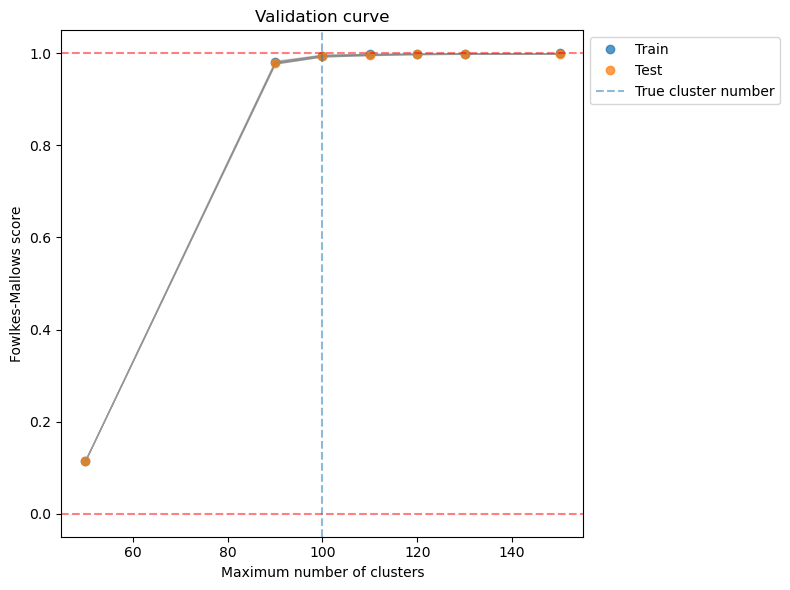

In [201]:
plt.figure(figsize=(8, 6))
plt.plot(params_range, t_means, 'o', alpha=0.75, label='Train')
plt.plot(params_range, v_means, 'o', alpha=0.75, label='Test')
plt.fill_between(params_range, t_downs, t_ups, color='gray', alpha=0.5)
plt.fill_between(params_range, v_downs, v_ups, color='gray', alpha=0.5)
plt.xlabel('Maximum number of clusters')
plt.ylabel('Fowlkes-Mallows score')
plt.title('Validation curve')
plt.axhline(0, color='red', linestyle='--', alpha=0.5)
plt.axhline(1, color='red', linestyle='--', alpha=0.5)
plt.axvline(100, linestyle='--', alpha=0.5, label='True cluster number')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
# plt.savefig(save_folder + 'v_curve_FMscore_diag.png', dpi=300)

In [232]:
n_comp = 120

# Create and fit the Bayesian Gaussian Mixture Model
bgmm = BayesianGaussianMixture(
    n_components=n_comp,      # Maximum number of components
    covariance_type='diag', # Type of covariance parameters
    max_iter=1000,         # Maximum number of iterations  
)

bgmm.fit(X_)

BayesianGaussianMixture(covariance_type='diag', max_iter=1000, n_components=120)

In [233]:
bgmm.score(X_)

-111052.01593680112

In [234]:
labels_pred = bgmm.predict(X_)
AMI = sklearn.metrics.adjusted_mutual_info_score(Y_, labels_pred)

In [235]:
weights = bgmm.weights_

In [209]:
sort_index = np.argsort(weights)

In [210]:
weights = weights[sort_index]

In [211]:
true_weights = np.array(num_observation_list)/np.sum(num_observation_list)

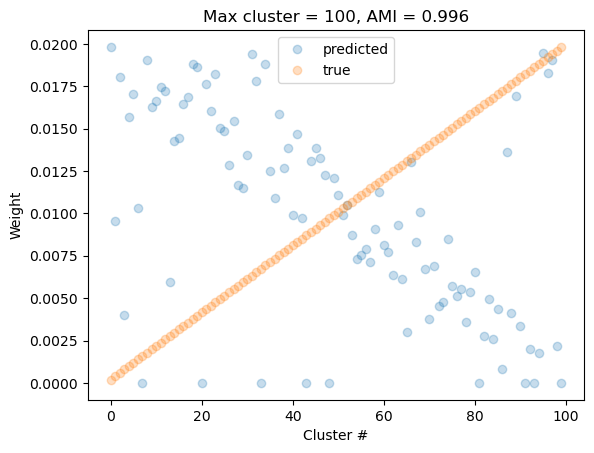

In [214]:
plt.plot(weights, 'o', alpha=0.25, label='predicted')
plt.plot(true_weights, 'o', alpha=0.25, label='true')
plt.xlabel('Cluster #')
plt.ylabel('Weight')
plt.title('Max cluster = {}, AMI = {}'.format(n_comp, np.round(AMI, 3)))
plt.legend()
# plt.savefig(save_folder+'weights_challenge_{}comp_diag_1.png'.format(n_comp), dpi=300)

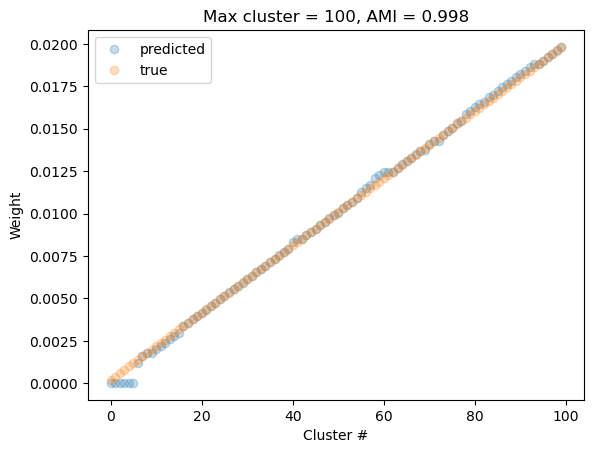

In [179]:
plt.plot(weights, 'o', alpha=0.25, label='predicted')
plt.plot(true_weights, 'o', alpha=0.25, label='true')
plt.xlabel('Cluster #')
plt.ylabel('Weight')
plt.title('Max cluster = {}, AMI = {}'.format(n_comp, np.round(AMI, 3)))
plt.legend()
plt.savefig(save_folder+'weights_challenge_{}comp_diag_2.png'.format(n_comp), dpi=300)

In [244]:
means = bgmm.means_

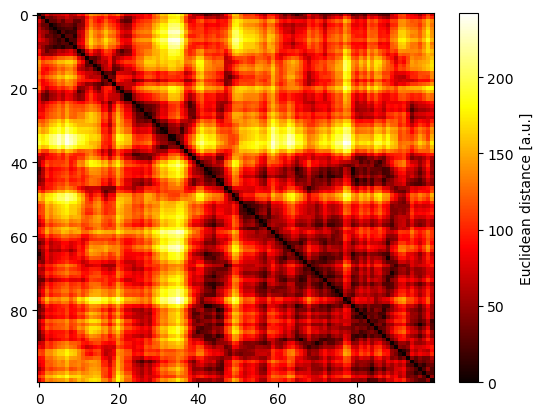

<Figure size 640x480 with 0 Axes>

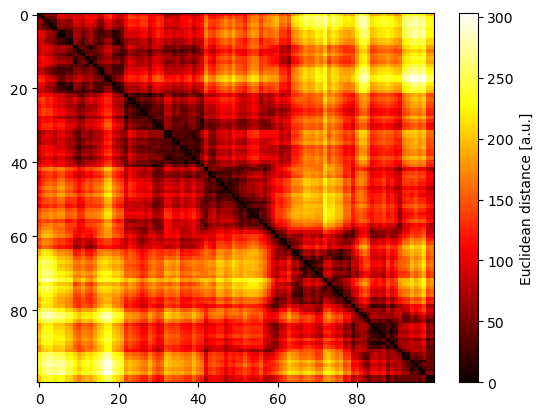

<Figure size 640x480 with 0 Axes>

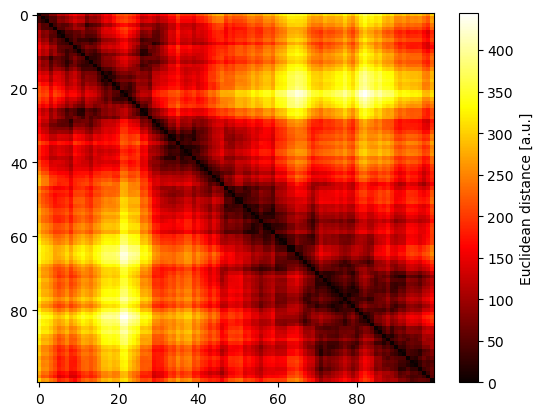

<Figure size 640x480 with 0 Axes>

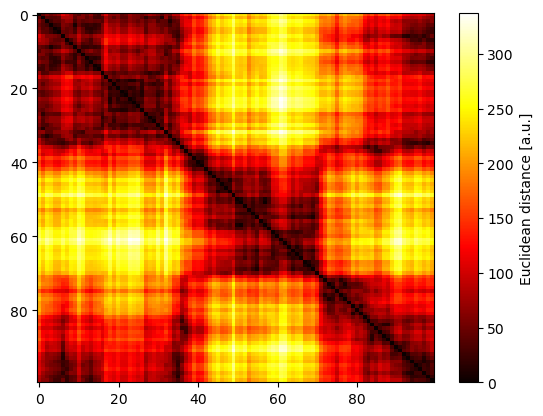

<Figure size 640x480 with 0 Axes>

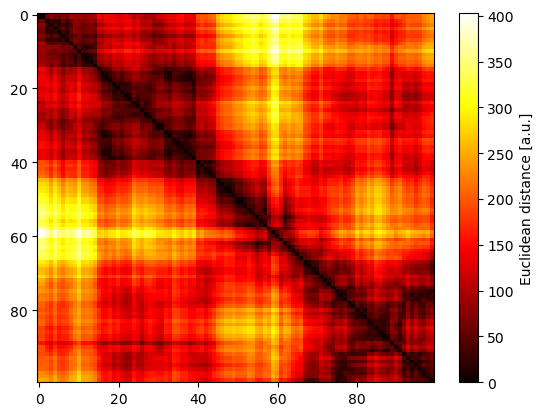

<Figure size 640x480 with 0 Axes>

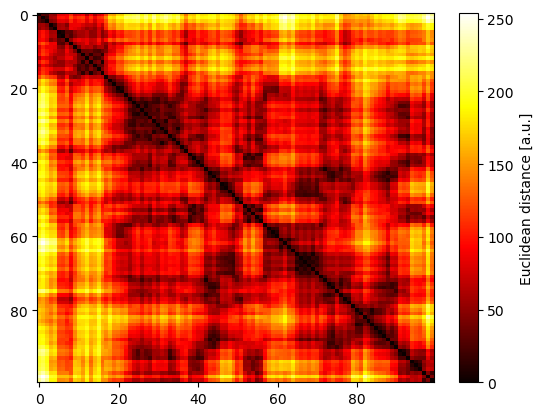

<Figure size 640x480 with 0 Axes>

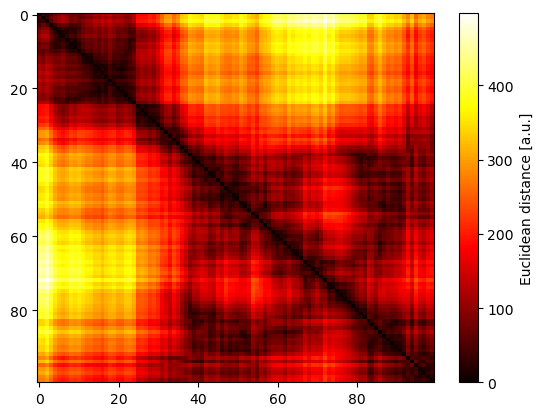

<Figure size 640x480 with 0 Axes>

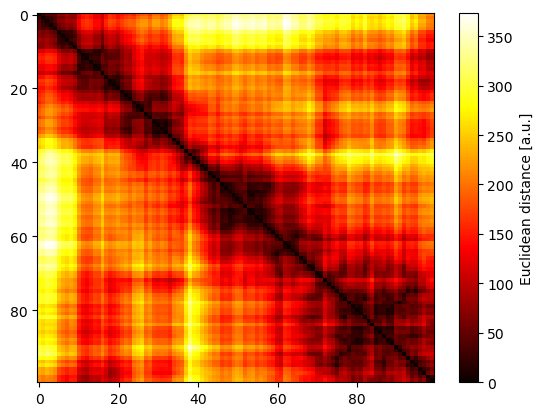

<Figure size 640x480 with 0 Axes>

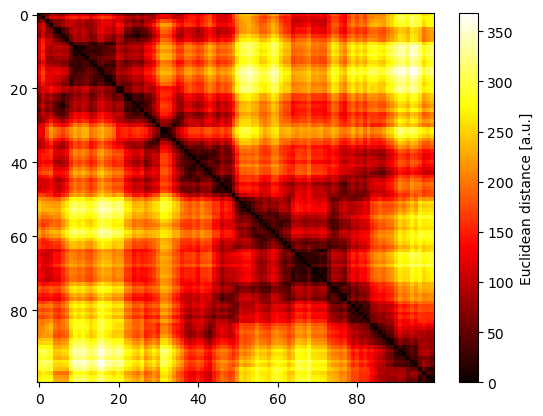

<Figure size 640x480 with 0 Axes>

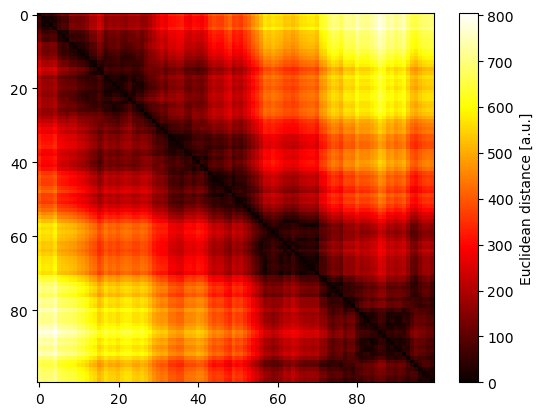

<Figure size 640x480 with 0 Axes>

In [181]:
for i in range(10):
    visualize_dmap(squareform(pdist(template_chain_list[i])))
    plt.savefig(save_folder+'dmap_{}.png'.format(i), dpi=300)

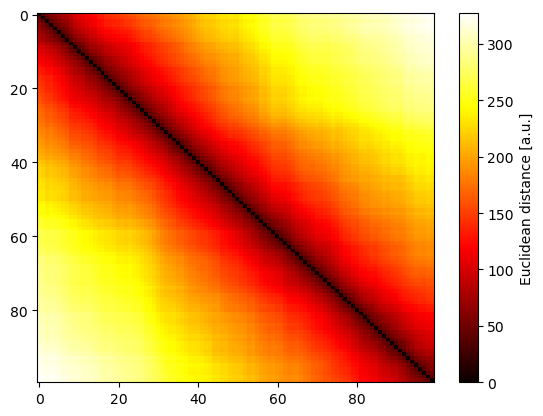

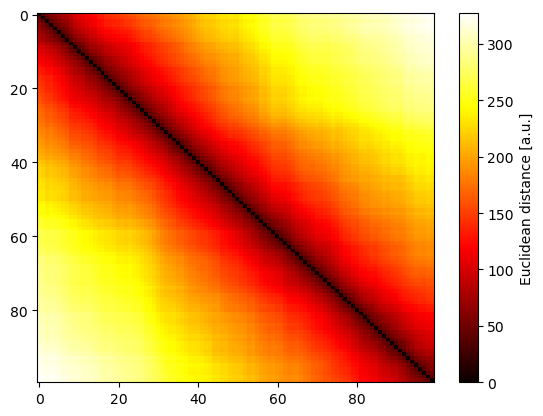

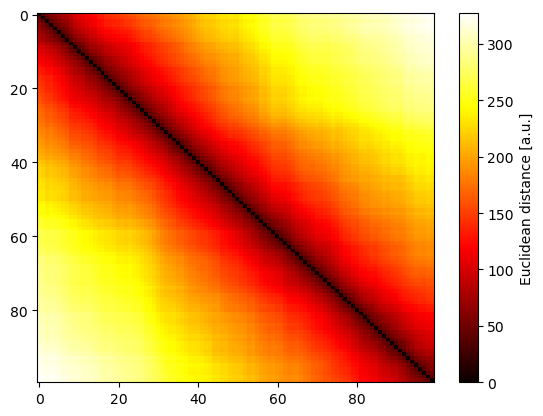

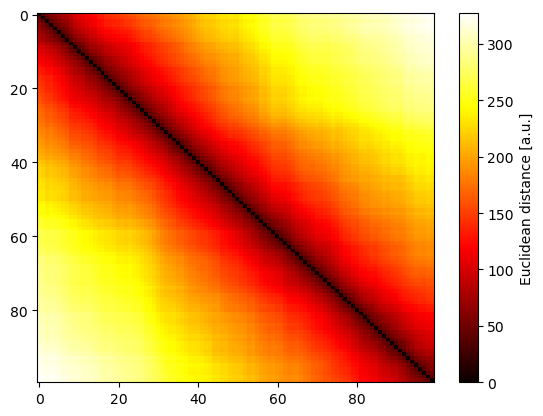

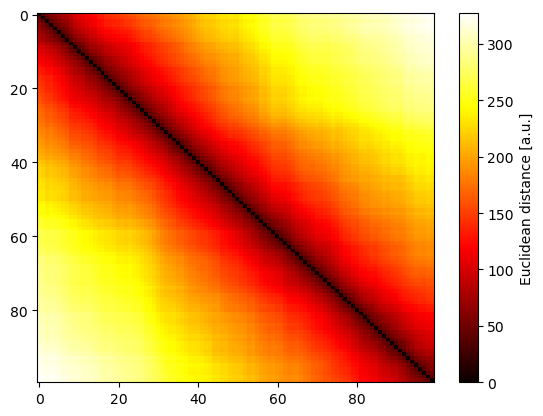

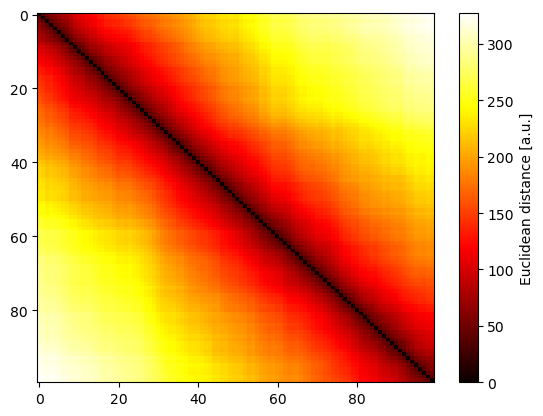

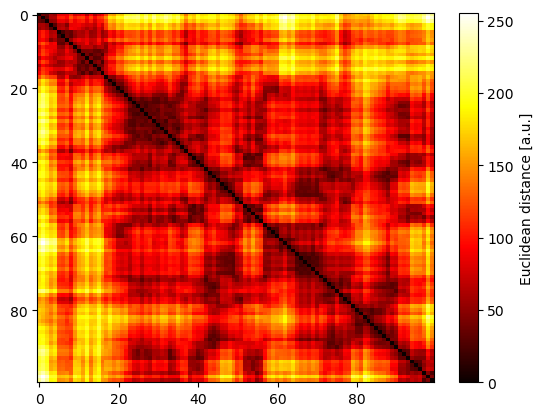

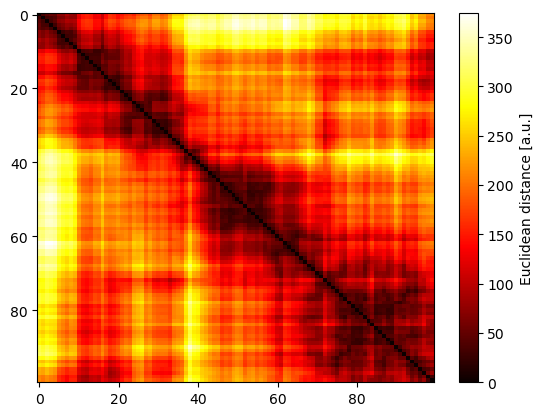

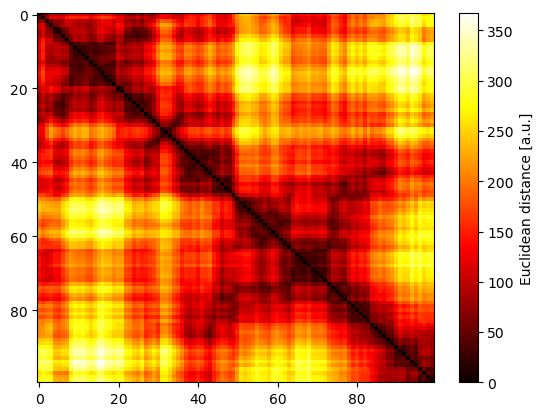

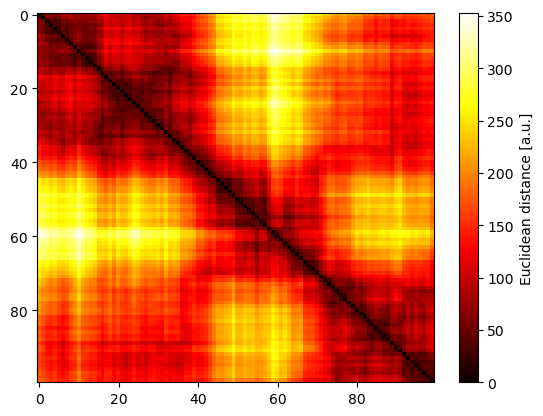

In [182]:
for i in range(10):
    visualize_dmap(means[sort_index][i].reshape(100, 100), save_path=save_folder+'dmap_pred{}_comp{}_diag.png'.format(i, n_comp))

In [245]:
true_dmaps = [squareform(pdist(x)).flatten() for x in template_chain_list]
pred_dmaps = means

In [246]:
pred_error_mat = cdist(pred_dmaps, true_dmaps)

In [247]:
row_ind, col_ind = linear_sum_assignment(pred_error_mat)

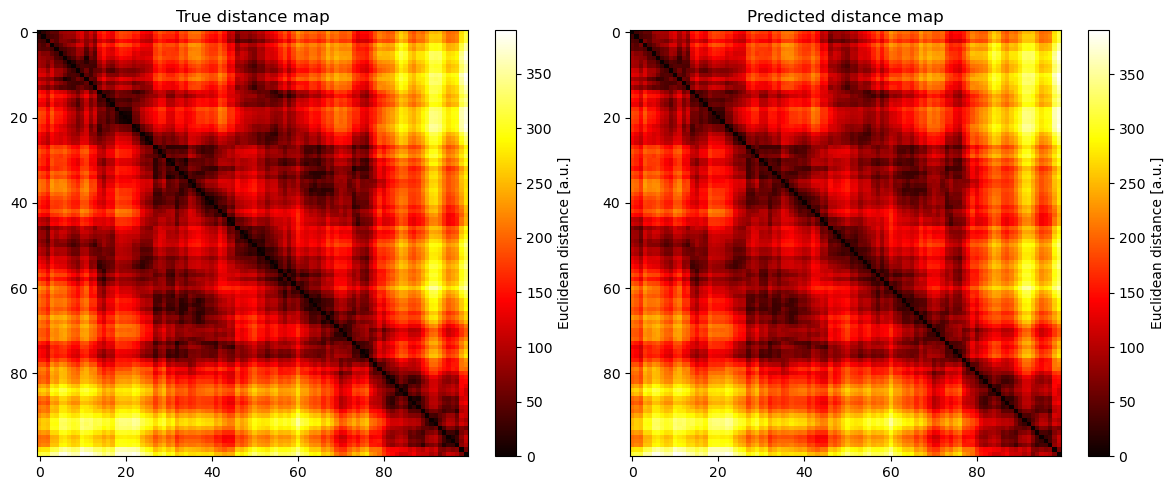

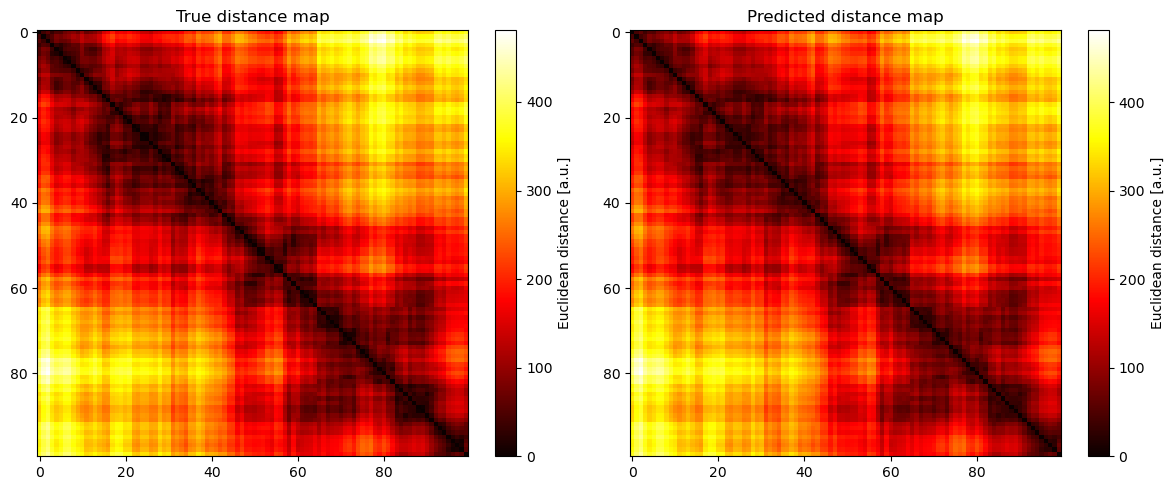

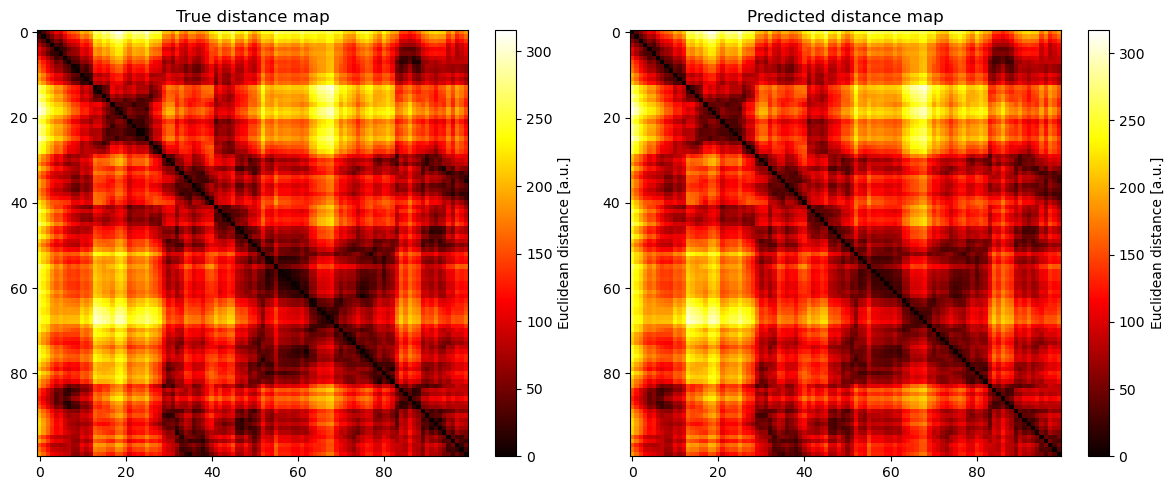

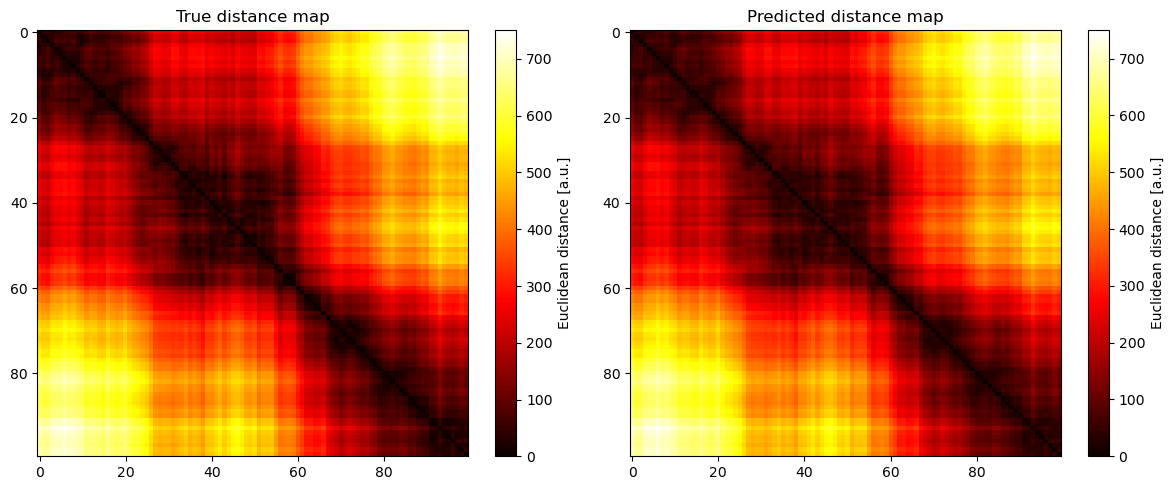

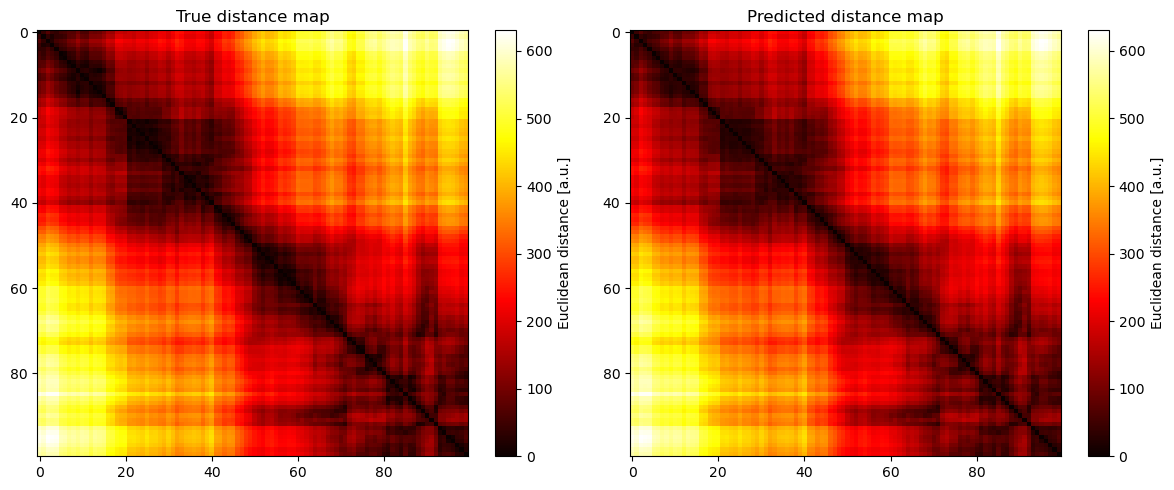

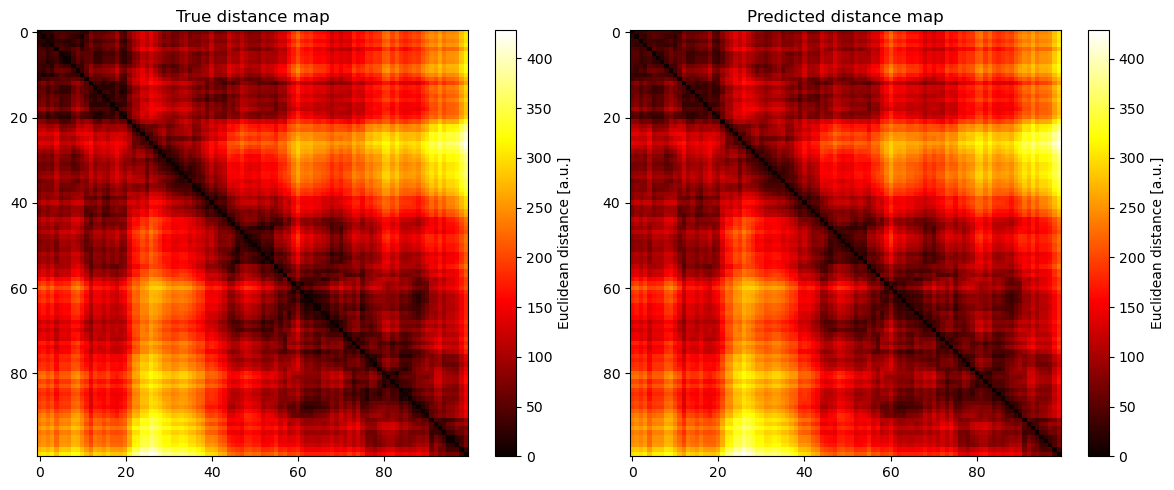

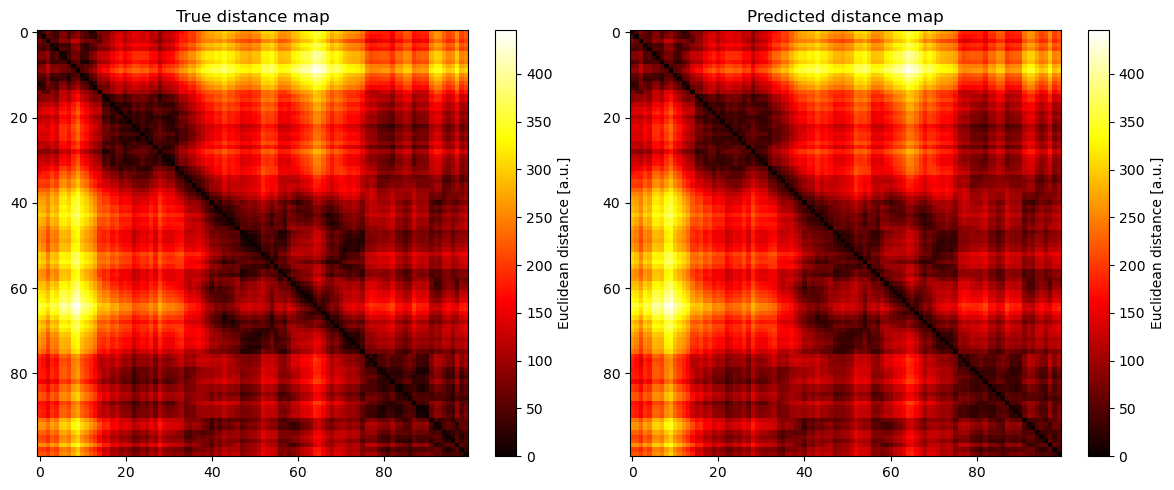

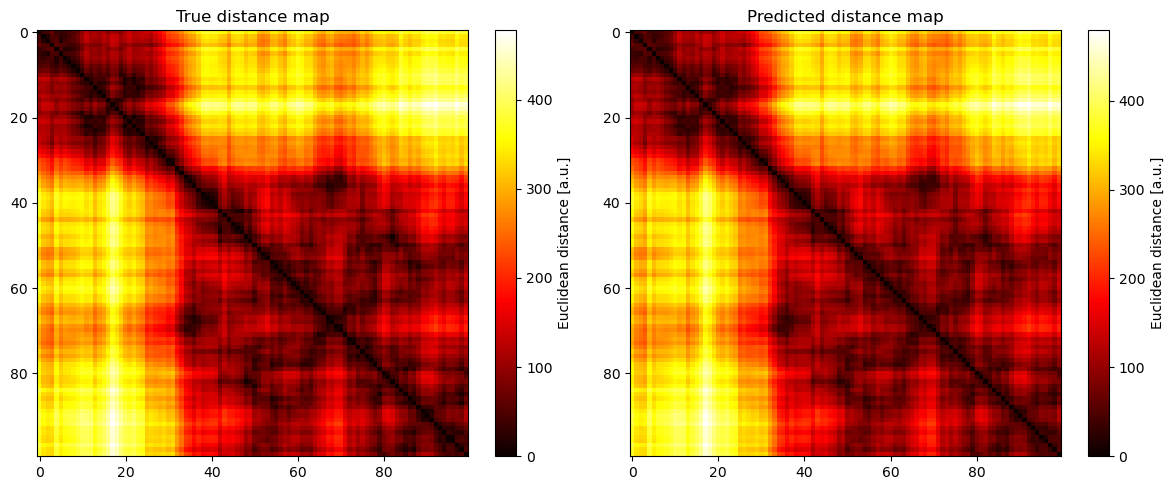

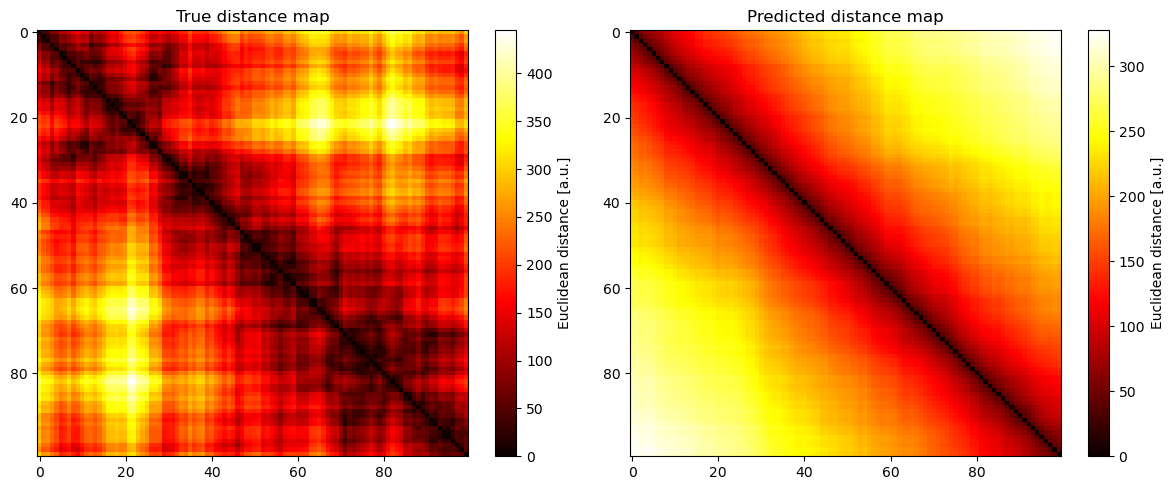

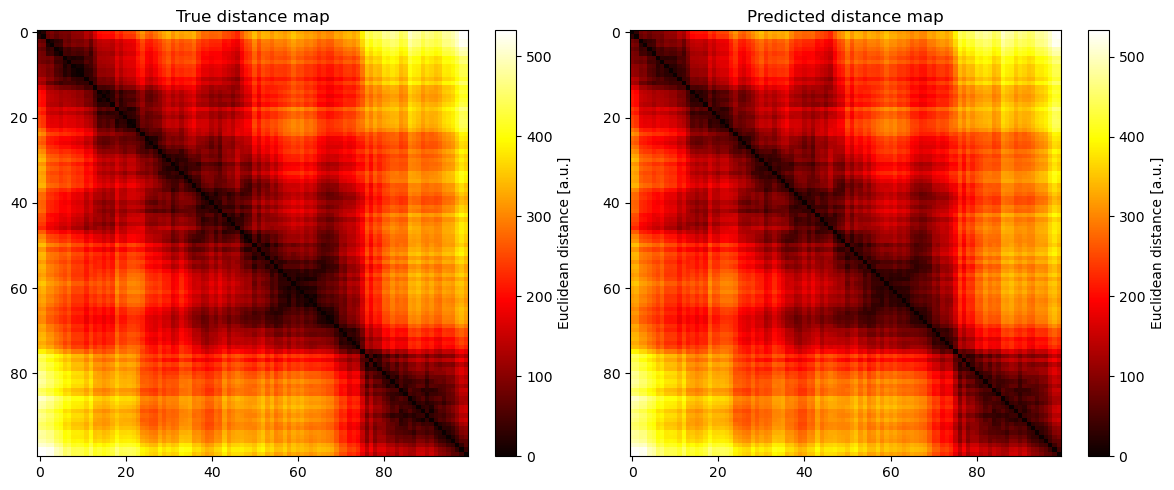

In [248]:
for i in range(0, 10): 
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    p1 = ax[0].imshow(true_dmaps[col_ind[i]].reshape(100, 100), cmap='hot', aspect='auto')
    cb1 = fig.colorbar(p1, ax=ax[0])
    cb1.set_label('Euclidean distance [a.u.]')
    ax[0].set_title('True distance map')
    p2 = ax[1].imshow(pred_dmaps[row_ind[i]].reshape(100, 100), cmap='hot', aspect='auto')
    cb2 = fig.colorbar(p2, ax=ax[1])
    cb2.set_label('Euclidean distance [a.u.]')
    ax[1].set_title('Predicted distance map')
    plt.tight_layout()
    # fig.savefig(save_folder+'dmap_assigned_pred{}_comp{}_diag.png'.format(i, n_comp), dpi=300)

In [267]:
row_ind

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        16,  18,  23,  24,  25,  27,  29,  30,  32,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  45,  46,  47,  48,  49,  50,  52,
        53,  55,  56,  57,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  89,  90,  91,  92,  93,  94,
        95,  97,  98, 100, 101, 102, 103, 104, 105, 106, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119])

In [249]:
weights_sort_indices = np.argsort(weights[row_ind])

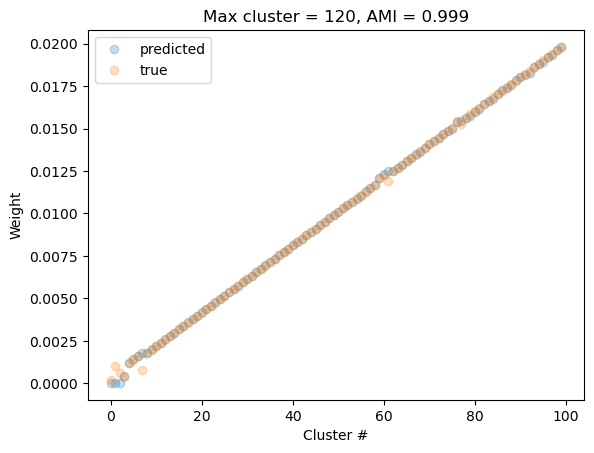

In [250]:
plt.plot(weights[row_ind][weights_sort_indices], 'o', alpha=0.25, label='predicted')
plt.plot(true_weights[col_ind][weights_sort_indices], 'o', alpha=0.25, label='true')
plt.xlabel('Cluster #')
plt.ylabel('Weight')
plt.title('Max cluster = {}, AMI = {}'.format(n_comp, np.round(AMI, 3)))
plt.legend()
plt.savefig(save_folder+'weights_assigned_challenge_comp{}_diag_2.png'.format(n_comp), dpi=300)

In [256]:
np.array(true_dmaps)[col_ind][weights_sort_indices];

array([[ 0.        , 40.21975604, 75.82313082, ..., 27.22368878,
        51.53579149,  0.        ],
       [ 0.        ,  2.04904822, 58.27245345, ..., 41.29207423,
        32.72450491,  0.        ],
       [ 0.        , 40.63190425, 40.56247111, ..., 62.01849104,
        54.91948012,  0.        ],
       ...,
       [ 0.        , 23.68904735, 25.61934987, ..., 40.16469107,
        12.32712553,  0.        ],
       [ 0.        , 12.77276613, 27.84443208, ..., 68.82222695,
        40.98141785,  0.        ],
       [ 0.        , 22.50814781, 48.76325522, ..., 49.7982584 ,
        35.32450985,  0.        ]])

In [264]:
weights.shape

(120,)

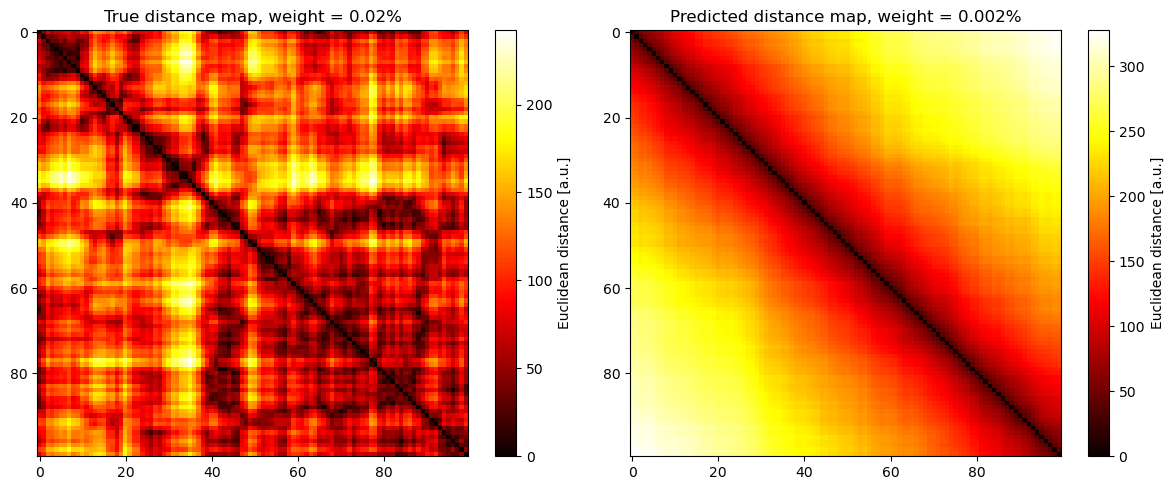

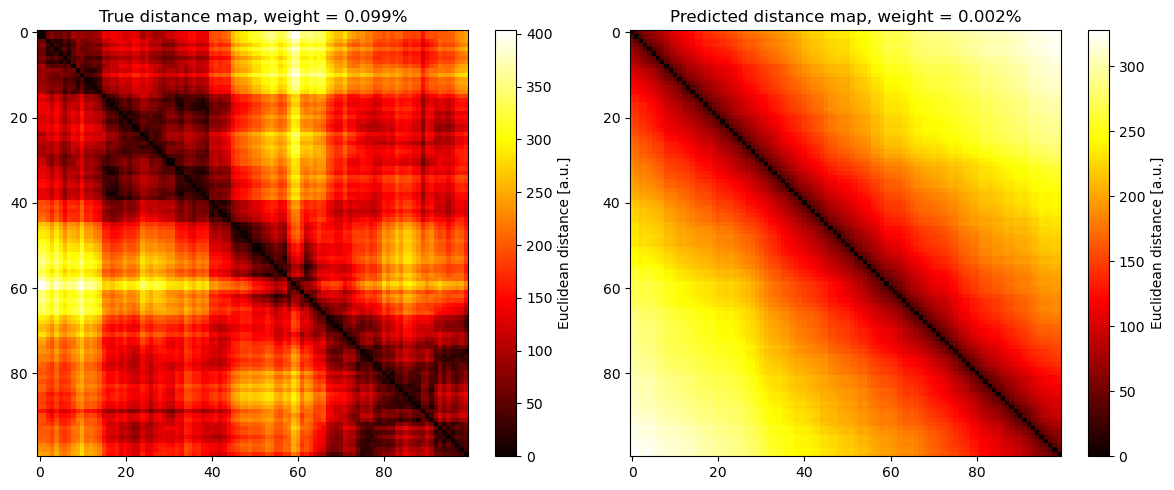

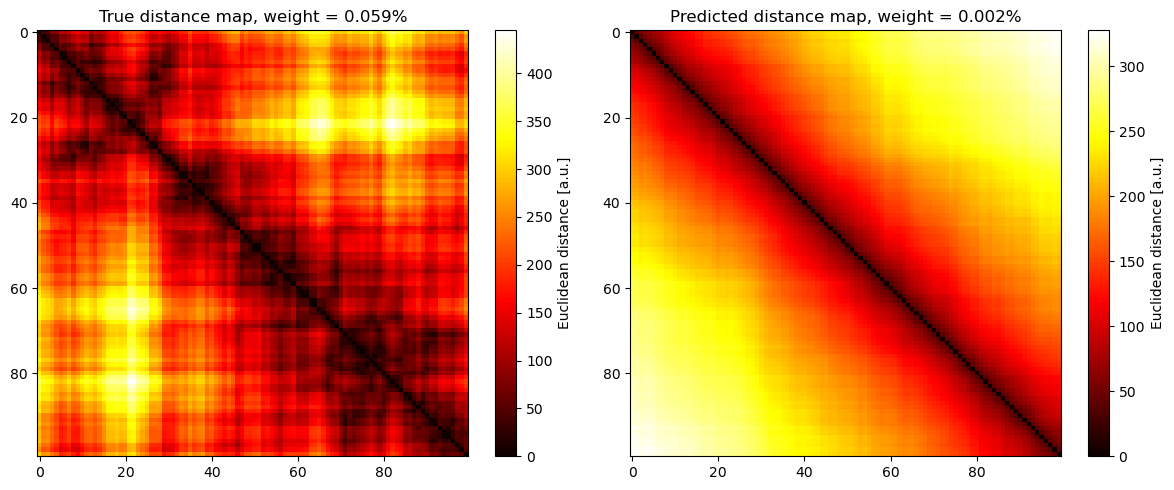

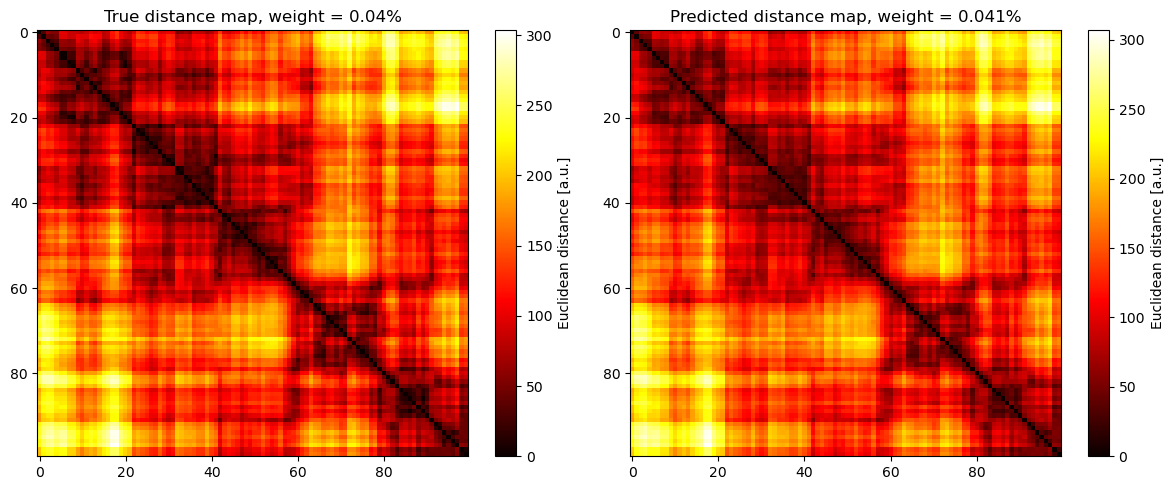

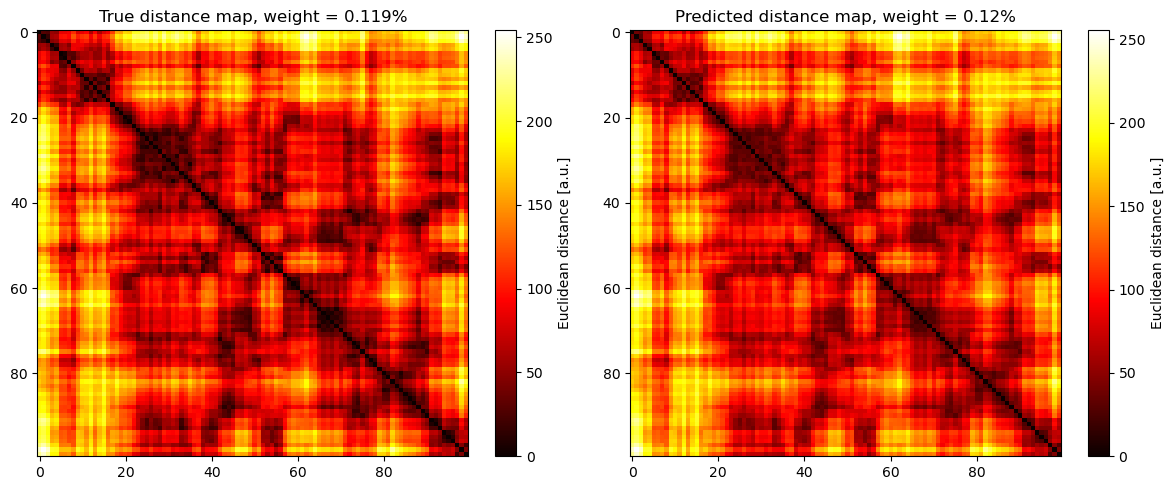

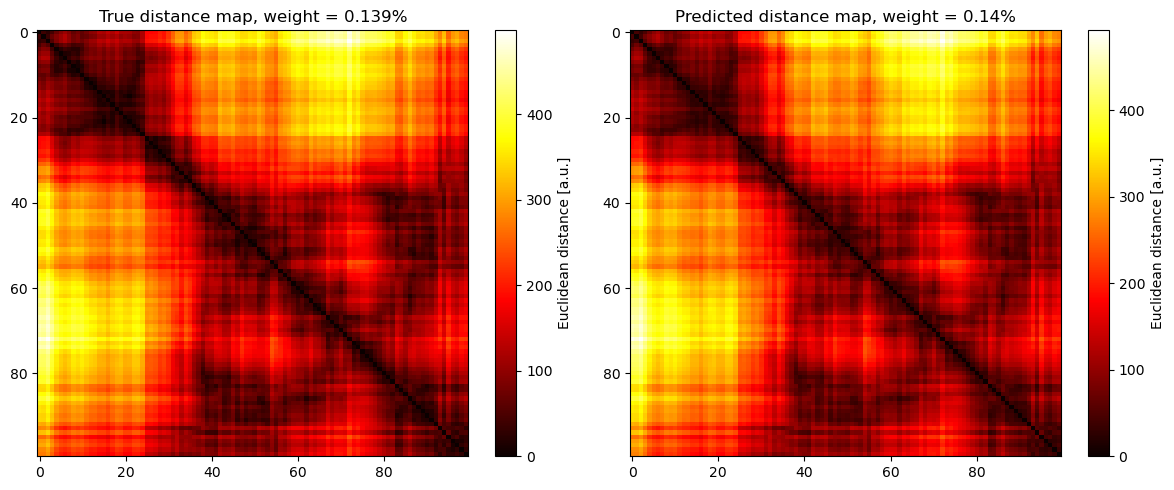

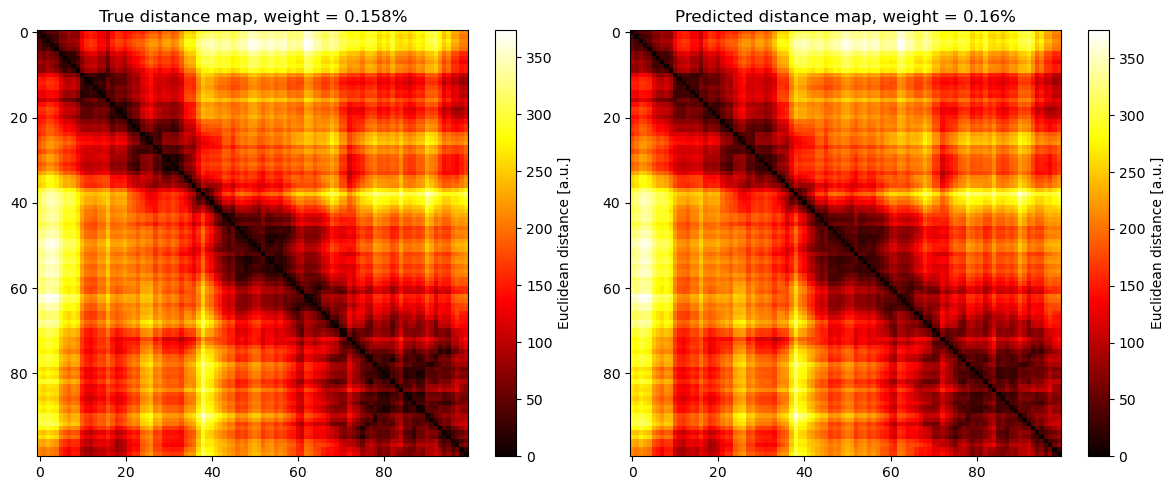

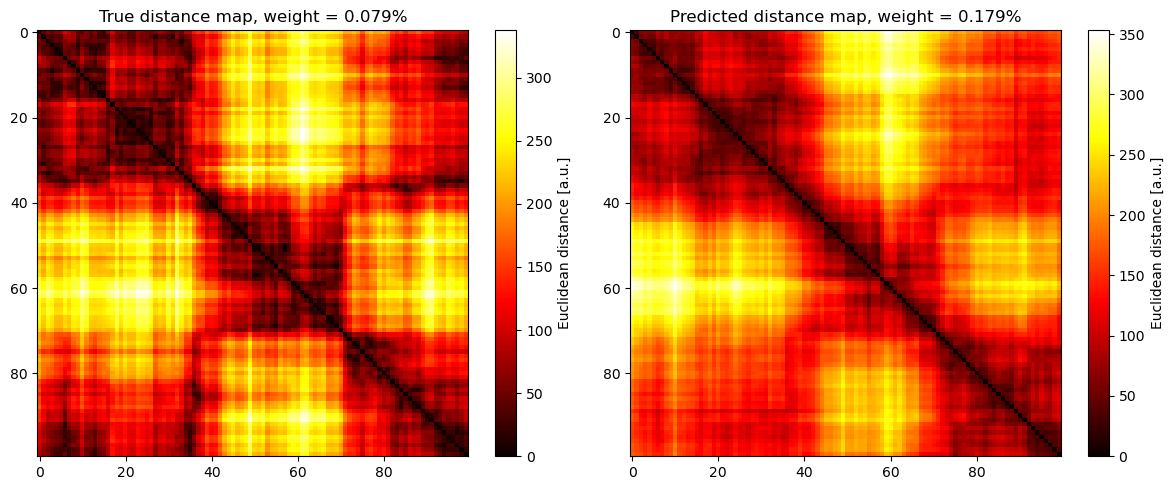

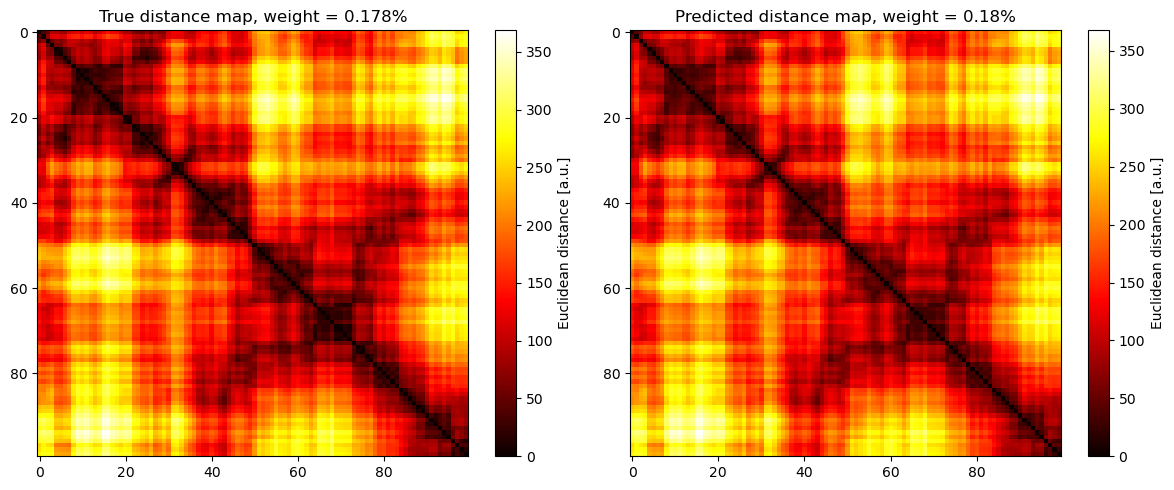

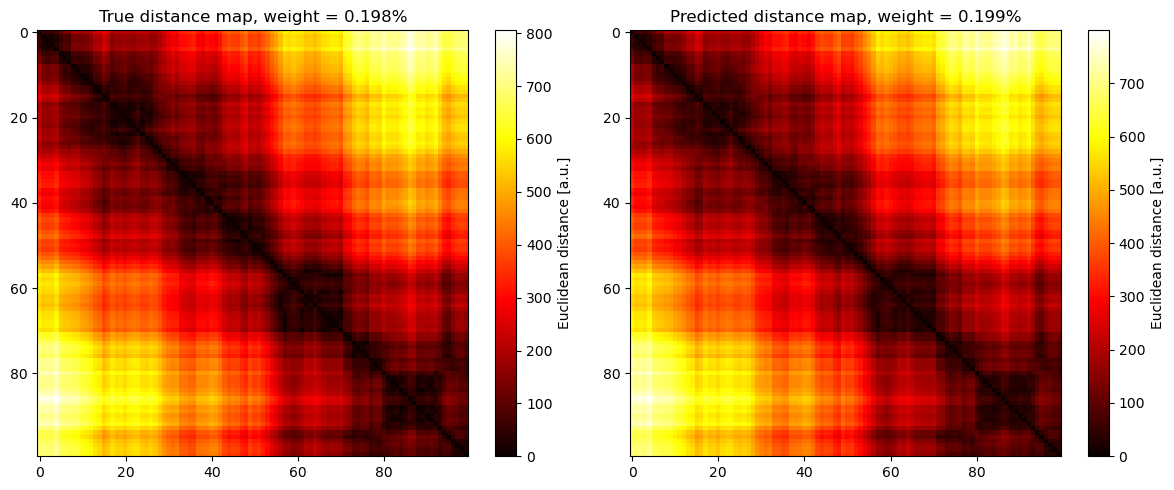

In [263]:
for i in range(0, 10): 
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    p1 = ax[0].imshow(np.array(true_dmaps)[col_ind][weights_sort_indices][i].reshape(100, 100), cmap='hot', aspect='auto')
    cb1 = fig.colorbar(p1, ax=ax[0])
    tw = np.round(true_weights[col_ind][weights_sort_indices][i]*100, 3)
    cb1.set_label('Euclidean distance [a.u.]')
    ax[0].set_title('True distance map, weight = {}%'.format(tw))
    p2 = ax[1].imshow(pred_dmaps[row_ind][weights_sort_indices][i].reshape(100, 100), cmap='hot', aspect='auto')
    cb2 = fig.colorbar(p2, ax=ax[1])
    pw = np.round(weights[row_ind][weights_sort_indices][i]*100, 3)
    cb2.set_label('Euclidean distance [a.u.]')
    ax[1].set_title('Predicted distance map, weight = {}%'.format(pw))
    plt.tight_layout()
    fig.savefig(save_folder+'dmap_assigned_pred{}_comp{}_low_weights_diag.png'.format(i, n_comp), dpi=300)

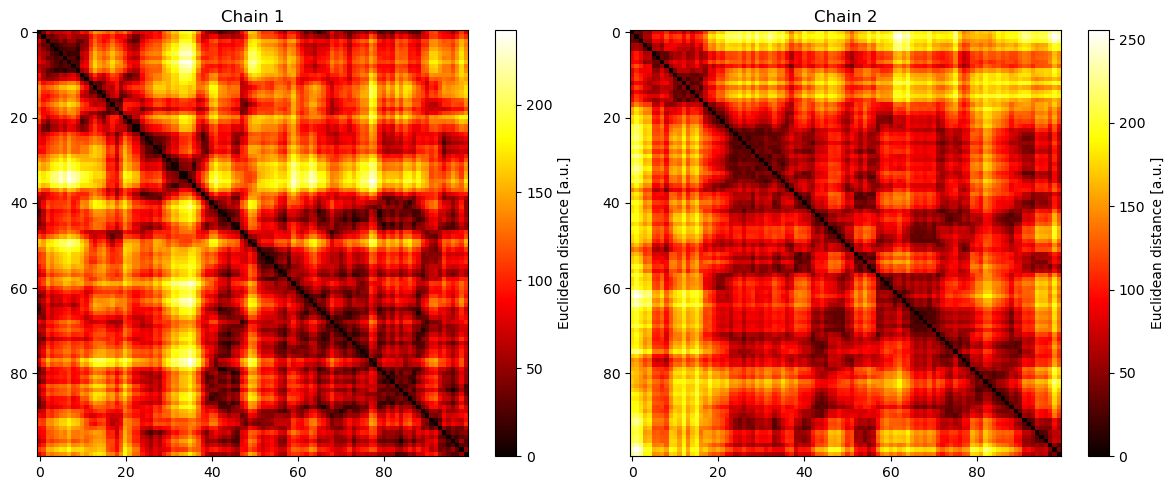

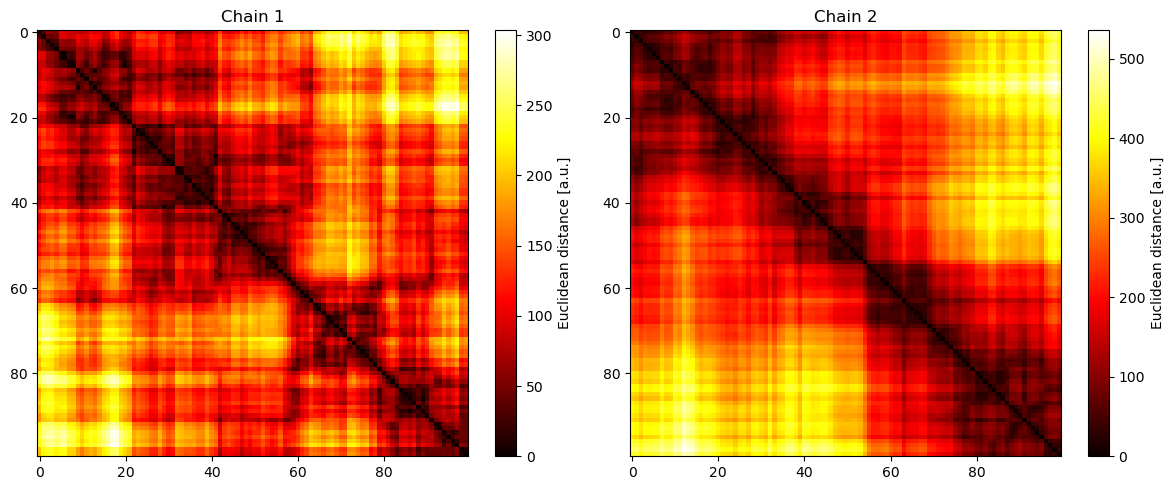

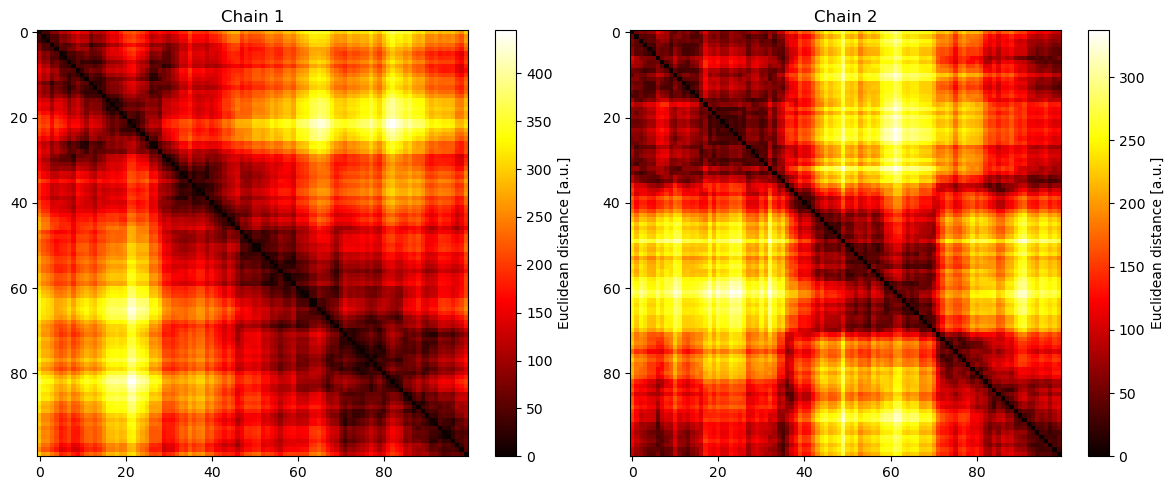

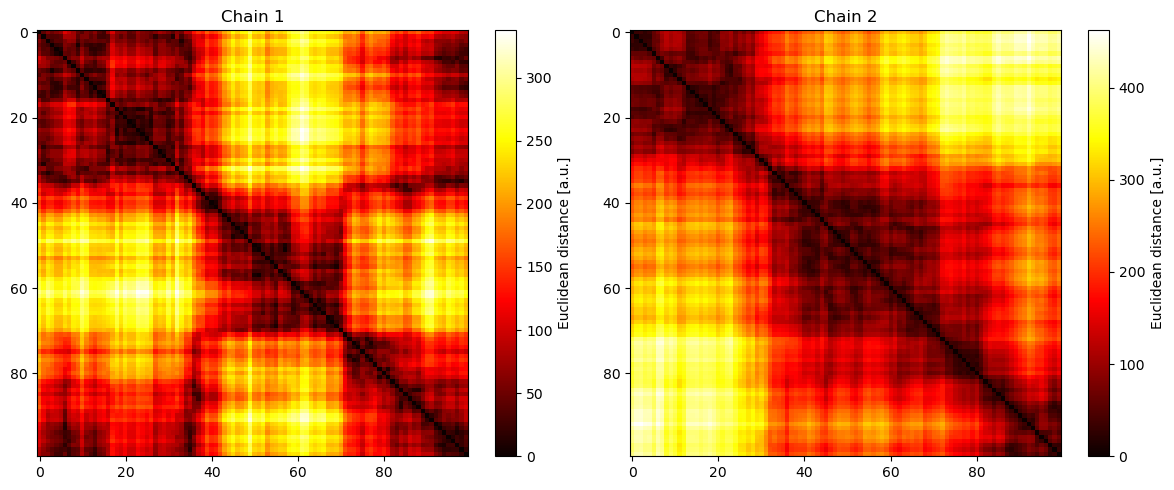

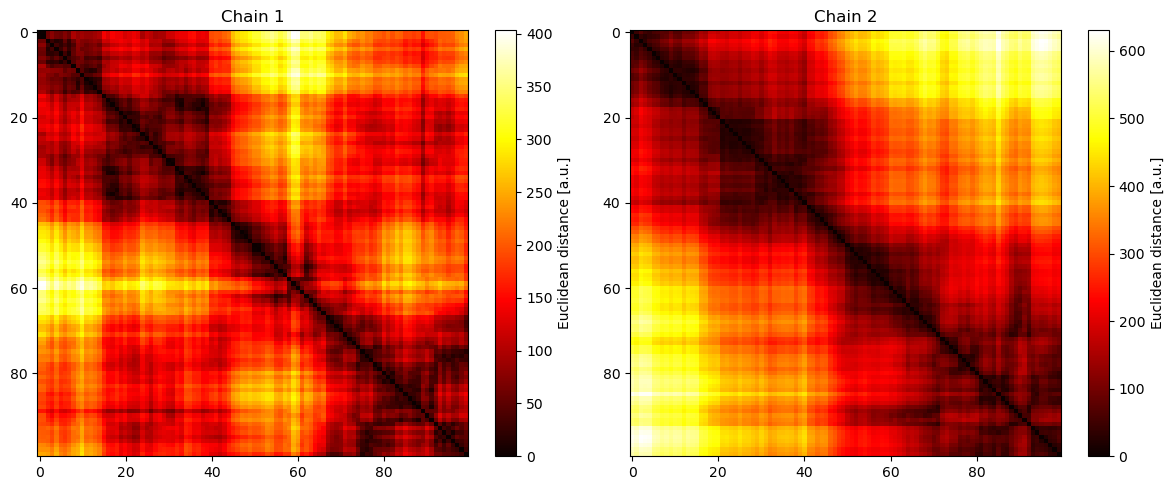

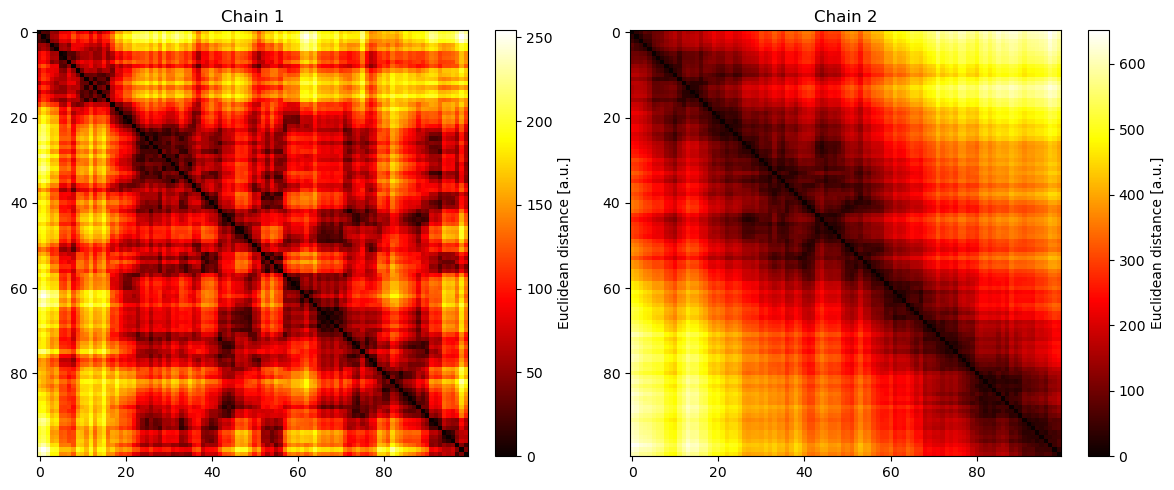

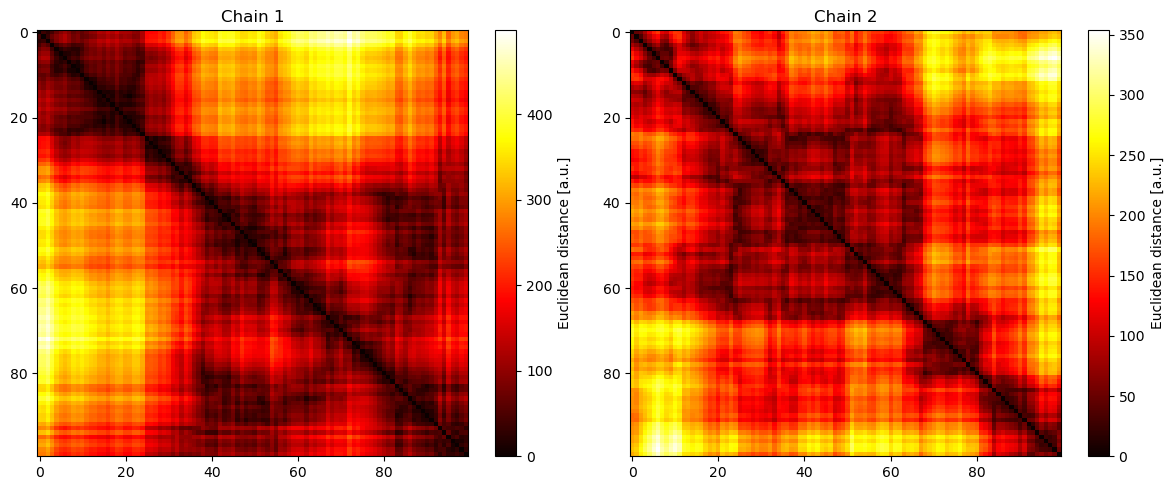

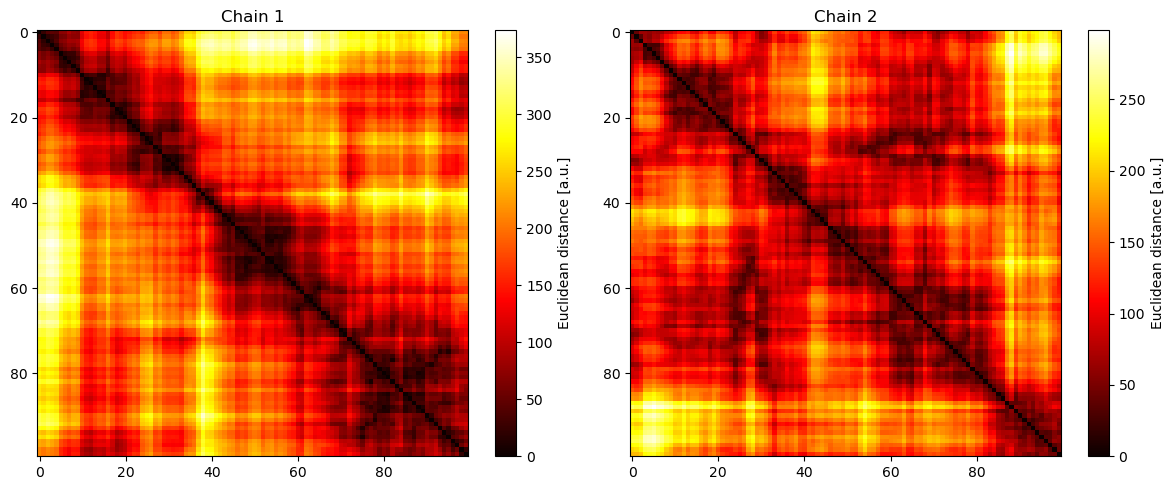

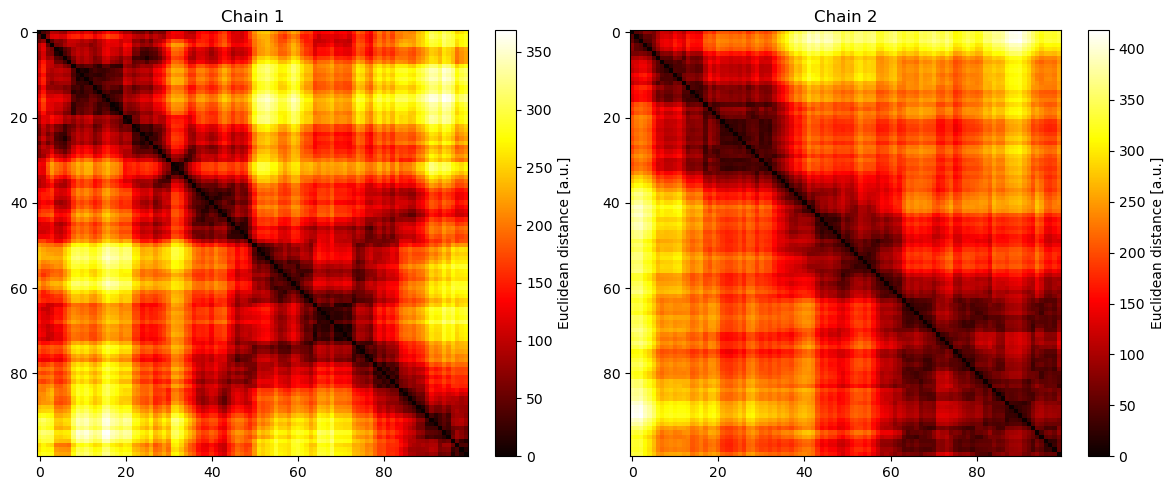

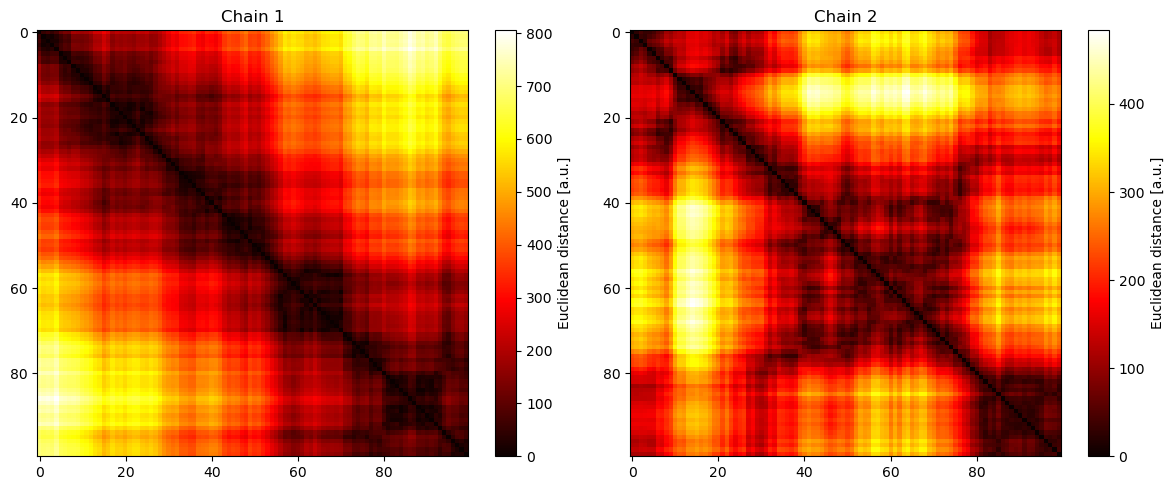

In [132]:
for i in range(10):
    true_dmap = squareform(pdist(template_chain_list[i]))
    pred_dmap = means[sort_index][i].reshape(100, 100)
    compare_distance_maps(true_dmap, pred_dmap, type1='distance_map', type2='distance_map')

In [284]:
bgmm

BayesianGaussianMixture(covariance_type='diag', max_iter=1000, n_components=120)

In [269]:
covariances = bgmm.covariances_

In [273]:
covariances[0, :]

array([5.83804143e-08, 8.87173810e+00, 1.07656268e+01, ...,
       1.13318079e+01, 1.01884873e+01, 5.83804143e-08])

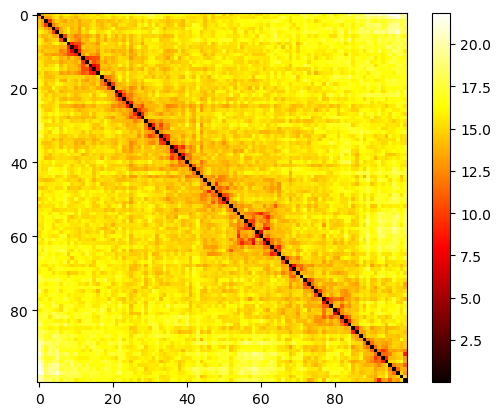

In [508]:
plt.imshow(covariances[row_ind][-3, :].reshape(100, 100), cmap='hot')
plt.colorbar()

In [309]:
X.shape

(50500, 10000)

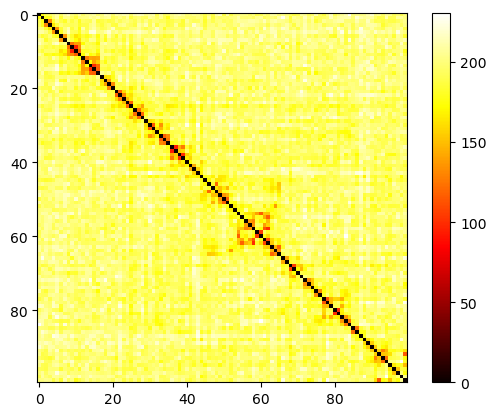

In [507]:
plt.imshow(np.var(X[Y==(col_ind[-3])].reshape(-1, 100, 100), axis=0), cmap='hot')
plt.colorbar()

In [418]:
eff_var = std_bond_length**2 + gaussian_noise_std**2
# eff_var = std_bond_length**2

In [421]:
# struct_var = ((eff_var**2 + (2*eff_var*mean_bond_length**2))/(2*(eff_var + mean_bond_length**2)))
struct_var = 0.5*eff_var*(1+2*)

In [492]:
def struct_var(mean, var, n):
    numerator = n*var**2 + 2*n**2*mean**2*var
    denominator = 2*(var + n*mean**2)
    return numerator/denominator

In [464]:
variance_matrix = np.zeros([100, 100])

In [457]:
for i in range(100):
    for j in range(100):
        n = np.abs(i-j)
        var_theory = struct_var(mean_bond_length, eff_var, n)
        variance_matrix[i, j] = var_theory
        variance_matrix[j, i] = var_theory

In [493]:
def struct_var_noise(var, polymer_chain, i, j):
    d_1 = np.sum(polymer_chain[i, :] - polymer_chain[j, :])
    d_2 = np.sum((polymer_chain[i, :] - polymer_chain[j, :])**2)
    # return 2*var*(2*d_1**2+var)/(4*(d_2 + var))
    numerator = 24*(d_1**2)*var + 18*var**2
    denominator = 4*(d_2 + 6*var)
    return numerator/denominator

In [517]:
for i in range(100):
    for j in range(100):
        var_theory = struct_var_noise(gaussian_noise_std**2, template_chain_list[-1], i, j)
        variance_matrix[i, j] = var_theory
        variance_matrix[j, i] = var_theory

In [518]:
gaussian_noise_std**2/2

50.0

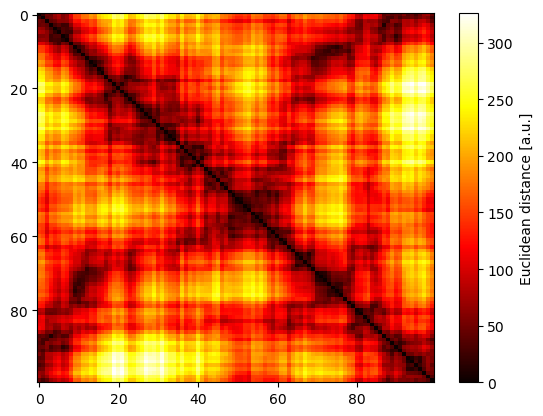

In [470]:
visualize_dmap(squareform(pdist(template_chain_list[-1])))

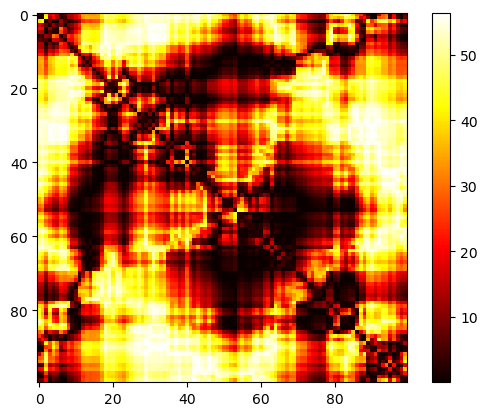

In [521]:
plt.imshow(variance_matrix/np.sqrt(num_observation_list[-1]), cmap='hot')
plt.colorbar()

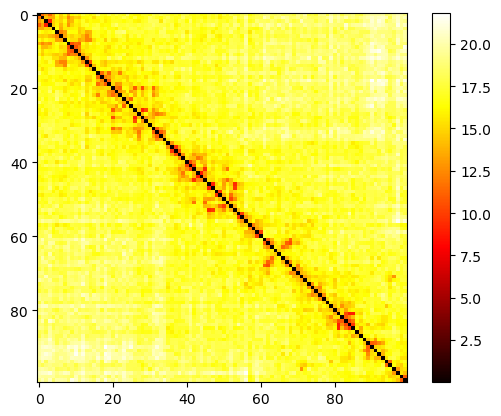

In [522]:
plt.imshow(covariances[row_ind][-1, :].reshape(100, 100), cmap='hot')
plt.colorbar()

In [406]:
np.sqrt(struct_var)

14.159758229475777

In [389]:
np.median(true_var)

193.87340542235356

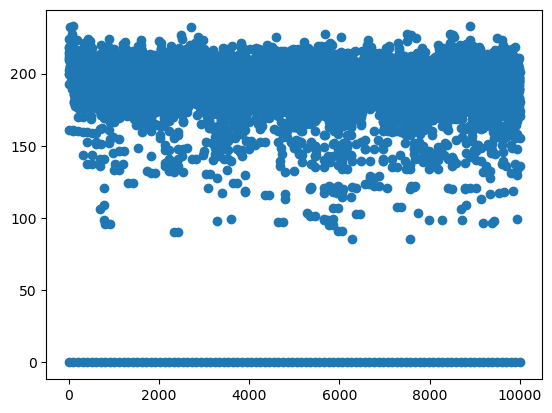

In [382]:
plt.plot(true_var, 'o')

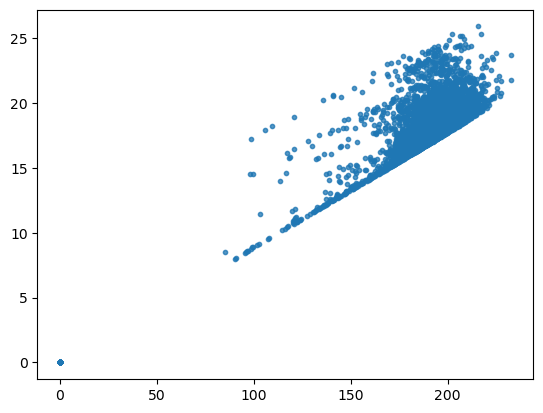

In [381]:
true_var = np.var(X[Y==col_ind[2]].reshape(-1, 100, 100), axis=0).reshape(-1) 
pred_var = covariances[row_ind][2, :]
plt.scatter(true_var, pred_var, marker='.', alpha=0.5)

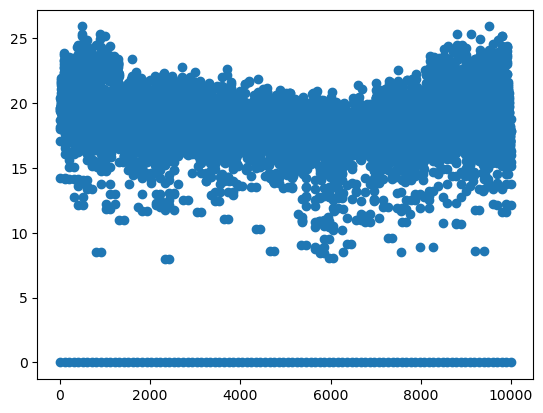

In [383]:
plt.plot(covariances[row_ind][2, :], 'o')

In [321]:
def create_distance_dataframe(array):
    # Get the shape of the array
    n = array.shape[0]
    
    # Initialize lists to store data
    values = []
    distances = []
    
    # Calculate values and distances
    for i in range(n):
        for j in range(n):
            values.append(array[i, j])
            distance = np.abs(i-j)
            distances.append(distance)
    
    # Create a pandas DataFrame
    df = pd.DataFrame({
        'Value': values,
        'Distance': distances
    })
    
    return df

In [423]:
X.reshape(-1, 100, 100)[0, :, :]

array([[  0.        ,  73.77304038,  98.05658225, ...,  73.45597055,
        114.55303733,  83.90522876],
       [ 73.77304038,   0.        ,  32.91756589, ...,  91.86734682,
        127.63256876, 121.29955552],
       [ 98.05658225,  32.91756589,   0.        , ..., 123.1536575 ,
        159.9473284 , 152.9181244 ],
       ...,
       [ 73.45597055,  91.86734682, 123.1536575 , ...,   0.        ,
         60.63072229,  33.74344687],
       [114.55303733, 127.63256876, 159.9473284 , ...,  60.63072229,
          0.        ,  58.93567221],
       [ 83.90522876, 121.29955552, 152.9181244 , ...,  33.74344687,
         58.93567221,   0.        ]])

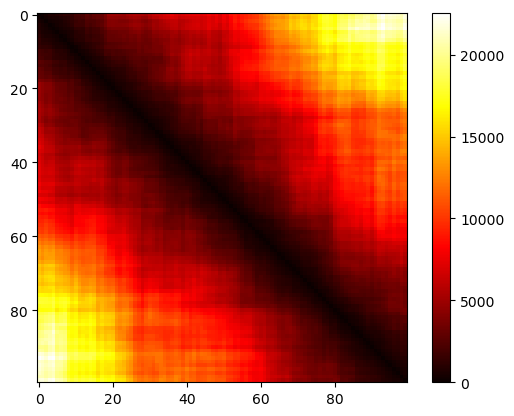

In [431]:
plt.imshow(np.var(X.reshape(-1, 100, 100), axis=0), cmap='hot')
plt.colorbar()

In [509]:
true_var_df = create_distance_dataframe(np.var(X[Y==col_ind[-1]].reshape(-1, 100, 100), axis=0))
pred_var_df = create_distance_dataframe(covariances[row_ind][-1, :].reshape(100, 100))

In [510]:
var_df = pd.concat([true_var_df, pred_var_df], axis=1)

In [513]:
var_df

true_var      pred_var  dist
0       0.000000  8.508692e-08     0
1     135.485674  1.155697e+01     1
2     154.915318  1.325778e+01     2
3     130.752831  1.130329e+01     3
4     157.581814  1.359347e+01     4
...          ...           ...   ...
9995  190.972231  1.630966e+01     4
9996  182.031761  1.553716e+01     3
9997  168.809162  1.441280e+01     2
9998  129.315899  1.104449e+01     1
9999    0.000000  8.508692e-08     0

[10000 rows x 3 columns]

In [512]:
var_df.columns = ['true_var', 'dist_1', 'pred_var', 'dist']
var_df.drop(columns=['dist_1'], inplace=True)

<Axes: xlabel='true_var', ylabel='pred_var'>

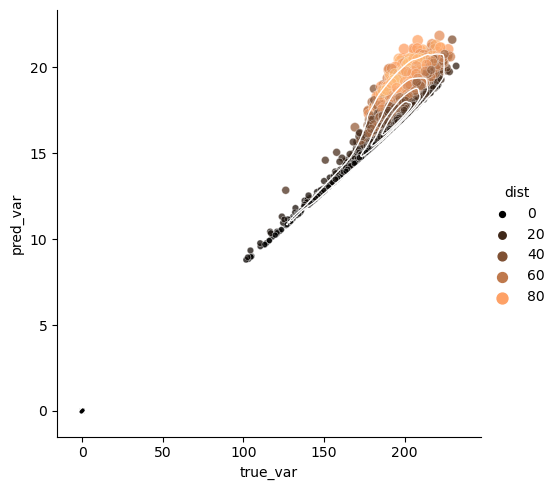

In [514]:
sns.relplot(
    data=var_df, x='true_var', y='pred_var',
    hue='dist', size='dist',
    alpha=0.5, palette='copper'
)
sns.kdeplot(
    data=var_df, x='true_var', y='pred_var',
    levels=5, color="w", linewidths=1
)

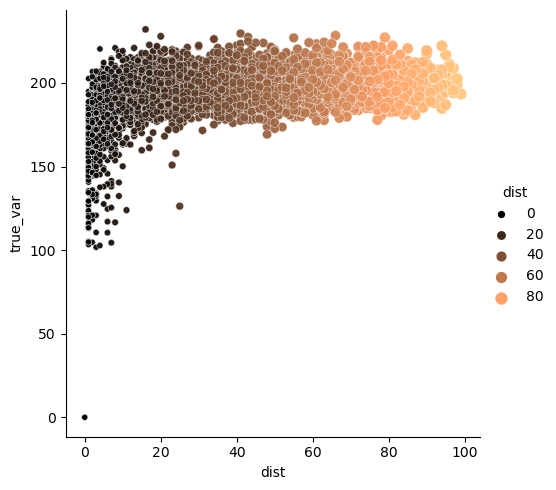

In [516]:
sns.relplot(
    data=var_df, x='dist', y='true_var',
    hue='dist', size='dist',
    alpha=0.75, palette='copper'
)


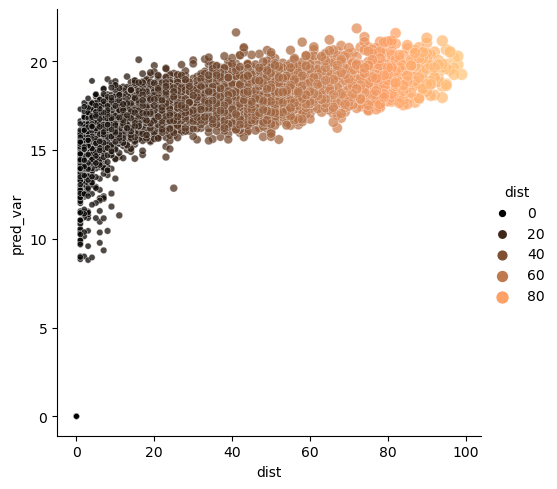

In [515]:
sns.relplot(
    data=var_df, x='dist', y='pred_var',
    hue='dist', size='dist',
    alpha=0.5, palette='copper'
)


In [351]:
true_mean_df = create_distance_dataframe(true_dmaps[col_ind[2]].reshape(100, 100))
pred_mean_df = create_distance_dataframe(pred_dmaps[row_ind[2]].reshape(100, 100))
mean_df = pd.concat([true_mean_df, pred_mean_df], axis=1)
mean_df.columns = ['true_mean', 'dist_1', 'pred_mean', 'dist']
mean_df.drop(columns=['dist_1'], inplace=True)

In [354]:
mean_df.loc[mean_df.dist==0, :]

true_mean  pred_mean  dist
0           0.0        0.0     0
101         0.0        0.0     0
202         0.0        0.0     0
303         0.0        0.0     0
404         0.0        0.0     0
...         ...        ...   ...
9595        0.0        0.0     0
9696        0.0        0.0     0
9797        0.0        0.0     0
9898        0.0        0.0     0
9999        0.0        0.0     0

[100 rows x 3 columns]

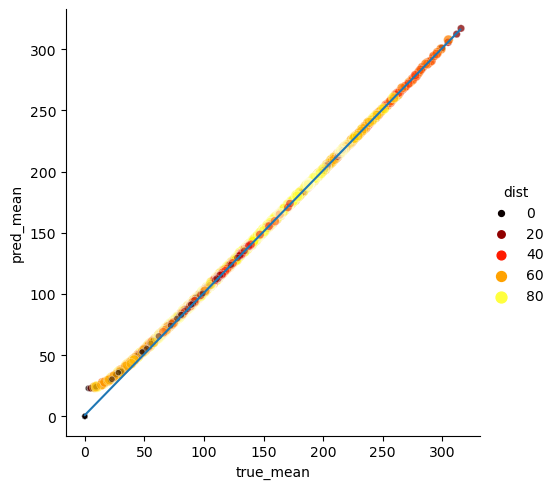

In [358]:
sns.relplot(
    data=mean_df, x='true_mean', y='pred_mean',
    hue='dist', size='dist',
    alpha=0.5, palette='hot'
)
plt.plot(np.arange(0, mean_df.true_mean.max()), np.arange(1, mean_df.pred_mean.max()))